# Compute MFCC using only Tensorflow 2.1

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


## Compute MFCC

In [55]:
from tensorflow.python.ops import io_ops
import numpy as np

In [56]:
# Data Set
candidates = []
candidates.append({'file': '/tf/tests/test_environment/audio/DevNode1_ex1_1.wav', 'label': 'yes'})
candidates.append({'file': '/tf/tests/test_environment/audio/DevNode1_ex11_220.wav', 'label': 'yes'})
candidates.append({'file': '/tf/tests/test_environment/audio/DevNode1_ex43_1.wav', 'label': 'yes'})
candidates.append({'file': '/tf/tests/test_environment/audio/DevNode1_ex69_3.wav', 'label': 'yes'})

In [57]:
# create label dict（word -> index）
label_dict = {}
for item in candidates:
    val = item['label']
    if not val in label_dict:
        label_dict[val] = len(label_dict)

# create inverse label dict（index -> word）
inv_label_dict = {v: k for k, v in label_dict.items()}
inv_label_dict

{0: 'yes'}

In [58]:
# Load Audio File
# INPUT : string
# OUTPUT: (sample_size, )
def load_data(filename):

    wav_loader = io_ops.read_file(filename)
    data, sr = tf.audio.decode_wav(wav_loader,
                                   desired_channels=1,
                                   desired_samples=16000)

    # delete channel dimension
    # (sampling_rate, 1) -> (sampling_rate,)
    
    data = tf.squeeze(data)

    return data, sr

In [59]:
# compute STFT
# INPUT : (sample_size, )
# OUTPUT: (frame_size, fft_size // 2 + 1)
def get_stft_spectrogram(data, fft_size):
    # Input: A Tensor of [batch_size, num_samples]
    # mono PCM samples in the range [-1, 1]. 
    stfts = tf.signal.stft(data,
                           frame_length=480,
                           frame_step=160,
                           fft_length=fft_size)

    # determine the amplitude
    spectrograms = tf.abs(stfts)

    return spectrograms

In [60]:
# compute mel-Frequency
# INPUT : (frame_size, fft_size // 2 + 1)
# OUTPUT: (frame_size, mel_bin_size)
def get_mel(stfts, n_mel_bin):

    # STFT-bin
    # 257 (= FFT size / 2 + 1)
    n_stft_bin = stfts.shape[-1]
    
    # linear_to_mel_weight_matrix shape: (257, 128)
    # (FFT size / 2 + 1, num of mel bins)
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mel_bin,
        num_spectrogram_bins=n_stft_bin,
        sample_rate=16000,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0
    )
    
    # mel_spectrograms shape: (1, 98, 128)
    mel_spectrograms = tf.tensordot(
        stfts,                        # (1, 98, 257) 
        linear_to_mel_weight_matrix,  # (257, 128)
        1)
    
    # take the logarithm (add a small number to avoid log(0))
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    return log_mel_spectrograms

In [61]:
# compute MFCC
# INPUT : (frame_size, mel_bin_size)
# OUTPUT: (frame_size, n_mfcc_bin)
def get_mfcc(log_mel_spectrograms, n_mfcc_bin):

    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)
    mfcc_ = mfcc[..., :n_mfcc_bin]

    return mfcc_

In [62]:
# OUTPUT: (frame_size, n_mfcc_bin)
def get_feature(audio_path, fft_size, n_mel_bin, n_mfcc_bin):
    
    # read the audio
    audio_data, sr = load_data(audio_path)

    # find the feature value (STFT)
    stfts = get_stft_spectrogram(audio_data, fft_size)

    # find features (logarithmic mel spectrogram)
    log_mel_spectrograms = get_mel(stfts, n_mel_bin)

    # finding feature values (MFCC)
    mfcc = get_mfcc(log_mel_spectrograms, n_mfcc_bin)

    return mfcc

In [63]:
sample_count = len(candidates)
n_frame = 98
fft_size = 512
n_mel_bin = 128
n_mfcc_bin = 13

fingerprint_size = n_frame * n_mfcc_bin    # frame_size * mfcc_bin_size

# initialise
data = np.zeros((sample_count, fingerprint_size))
labels = np.zeros(sample_count)

for idx, val in enumerate(candidates):

    feature = get_feature(val['file'], fft_size, n_mel_bin, n_mfcc_bin)
    data[idx, :] = tf.reshape(feature, [-1])  # flattens into 1-D
    labels[idx] = label_dict[val['label']]

data_ = tf.reshape(data, [sample_count, n_frame, n_mfcc_bin])

In [64]:
print(data_.shape)
print(labels.shape)

(4, 98, 13)
(4,)


## Plots

In [23]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

In [24]:
# 2 x 2
num_row = 2
num_col = 2

In [52]:
def plot_feature(plot_sample_idx):

    # swap dimensions (frame, mfcc_index) --> (mfcc_index, frame)
    feature = tf.transpose(data_[plot_sample_idx], perm=[1, 0])

    # excluding 0-th coefficient
    feature = feature[1:,:]
    feature_= feature.numpy()

    plt.subplot(num_row, num_col, plot_sample_idx+1)
    librosa.display.specshow(feature_,
                             sr=16000,
                             hop_length=160, 
                             x_axis='time',
                             vmin=-20,
                             vmax=20,
                             cmap='jet')

    plt.title("MFCC {}".format(plot_sample_idx))
    cbar = plt.colorbar(format='%+2.0f')
    plt.ylabel('MFCC')
    plt.tight_layout()

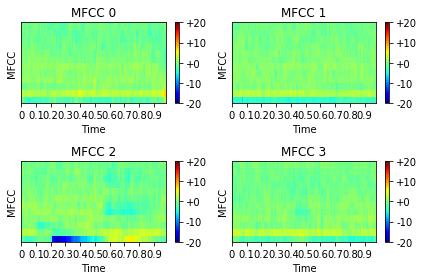

In [53]:
plot_feature(0)
plot_feature(1)
plot_feature(2)
plot_feature(3)

plt.show()